In [19]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [20]:
%presentation_style

In [21]:
%%capture

%set_random_seed 12

In [22]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h1>Neural Likelihood and Ratio Estimation</h1>
</div>

In [1]:
import math
import matplotlib.pyplot as plt
import sbi.analysis
import sbi.inference
import sbi.utils
import torch
import warnings

from sbi.utils import process_prior
from torch.distributions import LogNormal
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm.notebook import trange, tqdm

from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    load_sir_data,
)
from tfl_training_sbi.utils_models import save_posterior_obj
from tfl_training_sbi.utils_sir import eval_sir_model

# set manual seed for reproducibility
_ = torch.manual_seed(0)

# ignore user warnings
warnings.filterwarnings("ignore")

# configure storage location
storage = default_remote_storage()
c = get_config(reload=True)

## Outline

 - Recap of Neural Posterior Estimation 
 - Introduction to Neural Likelihood Estimation (NLE)
 - Exercise 
 - Neural Ratio Estimation (NRE)
 - Pros & Cons of all three methods
  

## Recap: the Goal of SBI

- We want to learn the posterior $p(\theta | \mathbf{x})$ of a model $\mathcal{M}$ given some data $\mathbf{x}$
- We do so using Bayes rule: 
    $$
    p(\theta | \mathbf{x}) = \frac{p(\mathbf{x} | \theta)
    p(\theta)}{p(\mathbf{x})}
    $$
- However, the Likelihood is usually intractable
- We overcome this challenge by sampling from the joint distribution
  $p(\mathbf{x}, \theta)=p(\mathbf{x}\mid \theta)p(\theta)$ and learn a conditional density estimator


## Recap: Neural Posterior Estimation

- Direct mapping from observations $\mathbf{x}$ to posterior $p(\theta|\mathbf{x})$
- E.g. learning Gaussian mixture, parameterized by neural network

## The Likelihood

- The Likelihood is the conditional probability density of the data given the model parameters, i.e. $p(\mathbf{x}|\theta)$
- This is a density function in $\mathbf{x}$ for fixed $\theta$

## Learning the Likelihood with a Neural Network

- NLE learns $p(\mathbf{x}|\theta)$ instead of $p(\theta|\mathbf{x})$
- Both are conditional density estimation problems ([NB 02](nb_02_conditional_density_estimation.ipynb))
- NLE is a Maximum Likelihood Estimation problem on $\{(\theta, \mathbf{x})_i
  \}^N_{i=1}$ where $\mathcal{M}(\theta_i) = \mathbf{x}_i$
- $\hat{p}(\theta \mid \mathbf{x}) = p(\theta\mid\mathbf{x})p(\theta)$ is a scaled version with constant $\frac{1}{p(\mathbf{x})}$ 


## Sampling from the NLE Posterior 

- In contrast to NPE, NLE and NRE require MCMC to sample from the posterior
- This should be taken into account when deciding which method to use
- We refer to the training _Introduction to Bayesian Machine Learning_ for a
  more in-depth coverage of accessing the posterior with MCMC


## Why should I use NLE

The goal is to obtain the posterior $p(\theta \mid \mathbf{x})$, why learn
$p(\mathbf{x} \mid \theta)$?

 - Reduced complexity due to factorization for i.i.d. observations 
 - Amortized when increasing the hierarchy 
 - Advantage when $\operatorname{dim}(\theta) \gg \operatorname{dim}(\mathbf{x})$
 - Only the Likelihood is intractable 
 - No correction for sequential learning 

## Quick Intro to the `sbi` Toolkit

- Open Source Software for Simulation-Based Inference; <i class="fa-brands fa-github"></i>[GitHub](https://www.mackelab.org/sbi/)
- Provides SNPE, SNLE and SNRE as well as analysis tools out of the box

In [2]:
# define a uninformative prior
prior = sbi.utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 1.0]) * 2
)


# define a simple simulator
def example_simulator(theta: torch.tensor):
    return torch.sin(theta) + torch.randn_like(theta) * 0.1


# obtain samples from joint distribution
thetas = prior.sample((1_000,))
x = example_simulator(thetas)


# use the first sample as observation
thetas, theta_obs = thetas[1:, :], thetas[0, :]
x, x_obs = x[1:, :], x[0, :]

In [3]:
# obtain a posterior approx. via NPE
inference = sbi.inference.SNPE(prior=prior, density_estimator="maf")
density_estimator = inference.append_simulations(thetas, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 126 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

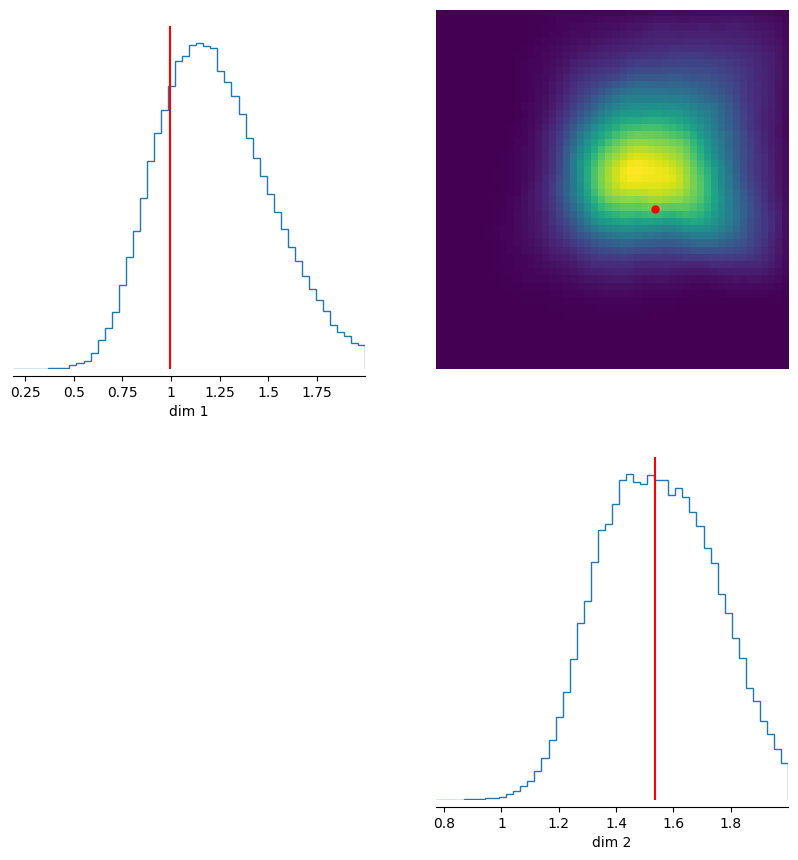

In [4]:
samples = posterior.sample((100_000,), x=x_obs)
_ = sbi.analysis.pairplot(
    samples=samples,
    points=theta_obs,
    points_colors="r",
    upper="kde",
)

## Example: Application of NLE on the SIR Dataset

We will use the same data as in the previous notebook, but now we will use the
neural likelihood estimator to construct the posterior.

**Task:** Use the provided the pseudo simulator to obtain the SIR dataset and
split it into a training and test set. Note, `sbi` standardizes the data itself. Therefore, this step can be omitted.


In [6]:
# load the pre-simulated data from disk
data_theta, data_x = load_sir_data(c.data)
data_theta, data_x = torch.tensor(data_theta), torch.tensor(data_x)

# separate the "observed" data from the training data
theta_obs, x_obs = data_theta[0,:], data_x[0,:]
theta_train, x_train = data_theta[1:,:], data_x[1:,:]


**Task:** Furthermore, we have to define a suitable prior to the task. As defined in the benchmarking paper by Lueckmann et al., we'll use a LogNormal distribution with the following parameters:
 - $\theta_1 \sim \operatorname{LogNormal}(\log 0.4, 0.5^2)$
 - $\theta_2 \sim \operatorname{LogNormal}(\log 0.125, 0.2^2)$

In [7]:
prior, _, _ = process_prior([
    LogNormal(
        loc=torch.tensor([math.log(0.4)]),
        scale=torch.tensor([0.5])
    ), 
    LogNormal(
        loc=torch.tensor([math.log(0.125)]),
        scale=torch.tensor([0.2])
    ),
])


**Task:** Finally, we can train the NDE. Therefore, we have to initialize a SNLE object with the respective prior and method for density estimation. Further, the training data has to be passed to the inference object. The NDE is trained by calling the `.train()` method on the inference object. Feel free to use the above example as blueprint. 

In [13]:
# obtain a posterior approx. via NPE
inference = sbi.inference.SNLE(prior=prior, density_estimator="maf")
density_estimator = inference.append_simulations(theta_train, x_train).train(
    training_batch_size=128, learning_rate=1e-4, max_num_epochs=200
)
posterior = inference.build_posterior(density_estimator, sample_with="mcmc")


 Training neural network. Epochs trained: 3

## Saving the Inference Object 

The training process of NLE inference objects can take long. Therefore, saving
the inference objects is advised. 

In [11]:
# saving the inference object for possible later use
save_posterior_obj("./notebooks/models/snle_sir.pl", inference)

## Let's Investigate the Learned Posterior 

In order to investigate the quality of approximation, we'll sample a large
number of $\theta$ from the conditional density $p(\theta \mid
\mathbf{x}_o)$.

We'll compare the resulting distribution to the actual $\theta^{\ast}$ that was
used to generate $\mathbf{x}_o$.  

**Task:** Similar to the example above, use the posterior, conditioned on `x_obs` to sample a large number of $\theta$. Then, plot the resulting samples using the pairplot, provided by the `sbi` toolkit. 

Running vectorized MCMC with 1 chains:   0%|          | 0/10100 [00:00<?, ?it/s]

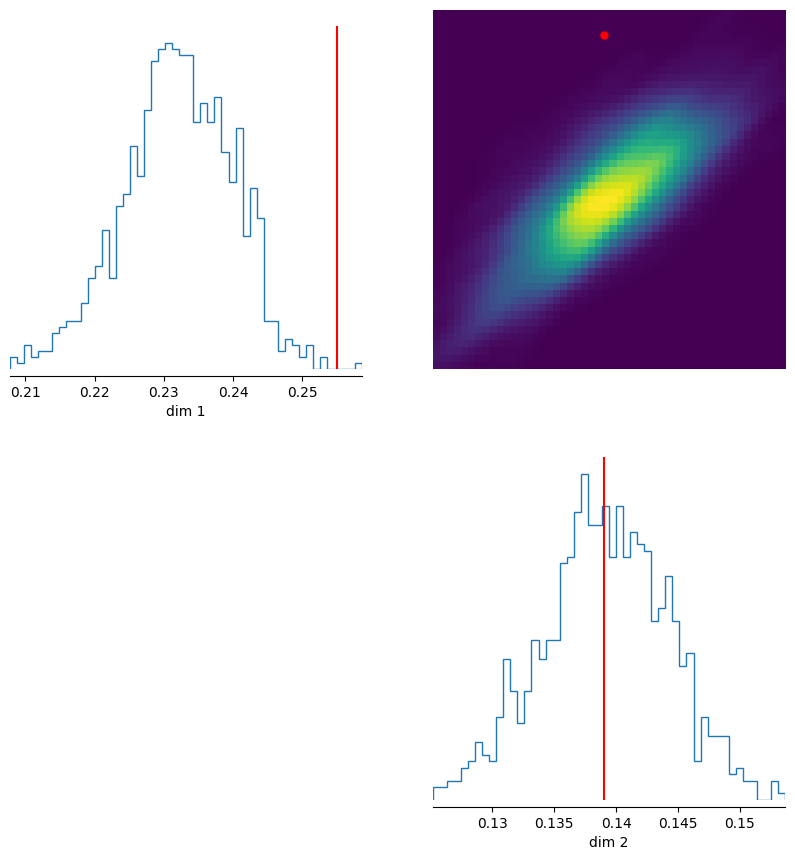

In [12]:
samples = posterior.sample((100_000,), x=x_obs, method="slice_np_vectorized")
_ = sbi.analysis.pairplot(
    samples=samples,
    points=theta_obs,
    points_colors="r",
    upper="kde",
)


## Neural Ratio Estimation 

- The Likelihood-ratio is a popular test statistic 

    $$
    r(\mathbf{x} \mid \theta_0, \theta_1) = \frac{p(\mathbf{x} \mid \theta_0)}{p(\mathbf{x} \mid \theta_1)}
    $$

- Cranmer et al (2015) have shown that $r(\mathbf{x}\mid \theta_0, \theta_1)$
  can be expressed by a classifier $d(\mathbf{x}, \theta)$ trained on
  samples from the true $p(\mathbf{x} \mid \theta)$ and an arbitrary but fixed
  hypothisis $p(\mathbf{x} \mid \theta_{\text{ref}})$

    $$
    \begin{align}
    d(\mathbf{x}, \theta) &= p(y=1 \mid \mathbf{x}) =
    \frac{p(\mathbf{x}\mid \theta)}{p(\mathbf{x}\mid \theta) + p(\mathbf{x}\mid
    \theta_{\text{ref}})}  \\
    r(\mathbf{x} \mid \theta_0, \theta_1) &= \frac{d(\mathbf{x},
    \theta)}{ 1 - d(\mathbf{x}, \theta) }
    \end{align}
    $$
  
  - Thus, learn a classifier to distinguish samples from $p(\mathbf{x},
    \theta)$ from $p(\mathbf{x})p(\theta)$


## Considerations about NRE

- Same concept as NLE but obtaining a normalized posterior 
- Sampling via MCMC 
- Training a classifier is easier than training a density estimator
- $d(\mathbf{x}, \theta)$ will be either $0$ or $1$ for many samples form
  $p(\mathbf{x}, \theta)$, makeing training more difficult

## Usage of NRE

- NRE is also implemented in the `sbi` toolkit

    ```python
    inference = sbi.inference.SNRE(prior)
    density_estimator = inference.append_simulations(thetas, x).train()
    posterior = inference.build_posterior(density_estimator)
    ```

## Practical Considerations for NPE vs. NLE and NRE

- NLE and NRE require MCMC; success depends on the shape and dimension of the
  posterior 
- Sequential approaches are helpful for high dimensional problems or costly
  simulations. However, SNPE might have issues on sharp boundaries of the prior
  and MCMC is slow
- Neural networks can take high dimensional inputs easily. Therefore, use NPE
  when $\dim(\mathbf{x}) \gg \dim(\theta)$ and NLE / NRE when $\dim(\mathbf{x})
  \ll \dim(\theta)$ 
- An appropriate feature extractor should be based on the data's structure. E.g.
  CNNs for images or RNNs for sequential data.

Luckily, SBI and its facets is an active area of research! 


## Summary 

| Method | Pros | Cons |
|:---|:---|:---|
|NPE | Amortized inference | Sequential version requires correction |
|NLE | Likelihood factors for i.i.d. samples, easy usage for hierarchical  problems | Requires MCMC, can be constly in higher dimensions |
|NRE | Likelihood factors for i.i.d. samples, training a classifier is easier than training an NDE | Requires MCMC, possible issues for $d$ close to either $0$ or $1$ |


## References

- sbi: A toolkit for simulation-based inference;
  [GitHub](https://www.mackelab.org/sbi/credits/)
- Cranmer et al. (2015), _"Approximating Likelihood Ratios with Calibrated Discriminative Classifiers"_
- Lueckmann et al. (2021), _"Benchmarking Simulation-Based Inference"_

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>